<a href="https://colab.research.google.com/github/MonkeyWrenchGang/MGTPython/blob/main/module_7/7_2_decision_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Churn Challenge 


---

Customer churn is a critical challenge for businesses across various industries, as it can significantly impact their revenue and profitability. It refers to the situation when customers discontinue their association with a company or stop using its products or services. The reasons behind churn can be numerous, ranging from poor customer service to the availability of better alternatives in the market.

The challenge: 

Suppose you are an employee of a telecommunications company like Verizon or AT&T, understanding and mitigating customer churn can be crucial for maintaining growth and success in the industry. With an annual valuation of $1200 per customer, losing customers can result in a significant loss of revenue for the company. Therefore, identifying the factors that influence customer churn and implementing strategies to retain customers can help mitigate this risk. 

The company belives that two critical factors that have been identified to influence customer churn are the network speed (5G or 4G LTE) and the phone model. Additionally, the company has observed that customers who opt for paperless billing are less likely to churn. Thus, focusing on providing superior network speed and offering desirable phone models while promoting paperless billing can be effective strategies to retain customers and reduce churn. 

Let's use our analytics skills to test these assertions and at the same time can we build a Decision Tree Classifier to identify likely churners before they churn?



In [51]:
# --------------------------------
import warnings
warnings.filterwarnings('ignore')
# --------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import seaborn as sns

# -- sklearn stuff -- 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# -- sklearn ML models -- 
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

# Import Data

In [52]:
churn = pd.read_csv("https://raw.githubusercontent.com/MonkeyWrenchGang/MGTPython/main/module_7/Churn_training.csv")
churn.head()

,monthly_minutes,customer_service_calls,streaming_minutes,total_billed,prev_balance,late_payments,ip_address_asn,phone_area_code,customer_reg_date,email_domain,...,currency_code,maling_code,paperless_billing,payment_method,customer_id,billing_address,gender,network_speed,senior_citizen,churn
0,22604.0,2.0,26525.0,285.0,47.0,5.0,16767.0,253.0,2020-04-15,yahoo.com,...,usd,H,No,Mailed Check,1-136-08562-9.1,5592 Gill Pine Suite 387,Female,5G,1.0,0
1,17059.0,2.0,16887.0,201.0,45.0,5.0,53966.0,241.0,2020-04-12,gmail.com,...,eur,V,Yes,Mailed Check,0-384-11264-1.2,5806 Kathleen Mount Suite 186,Male,5G,0.0,0
2,25848.0,2.0,26783.0,264.0,44.0,6.0,19278.0,232.0,2020-02-22,gmail.com,...,cad,R,Yes,Credit Card,0-08-151665-7.3,5037 Allen Square Apt. 727,Male,5G,1.0,0
3,22080.0,3.0,23649.0,274.0,49.0,6.0,16680.0,236.0,2020-08-05,yahoo.com,...,cad,N,No,Mailed Check,0-02-200816-0.4,841 Griffin Route Suite 824,Female,5G,0.0,0
4,23871.0,3.0,7705.0,236.0,61.0,5.0,51308.0,243.0,2019-11-16,gmail.com,...,cad,V,Yes,Electronic Check,0-87476-135-2.5,46185 Mejia Manor Apt. 558,Male,4Glte,1.0,0


# Describe Target


---

So about 5% of customers churn in this sample. 

In [53]:
churn["churn"].value_counts(normalize=False)

0    85926
1     4975
Name: churn, dtype: int64

In [54]:
churn["churn"].value_counts(normalize=True)

0    0.94527
1    0.05473
Name: churn, dtype: float64

# Nulls? 


---

The data is full of nulls so we know we'll need to deal with them when we build our Decision Tree. 



In [55]:
churn.isna().sum(axis=0)

monthly_minutes           20
customer_service_calls    22
streaming_minutes         22
total_billed              34
prev_balance              22
late_payments             20
ip_address_asn            17
phone_area_code           28
customer_reg_date         27
email_domain              28
phone_model               25
billing_city              29
billing_postal            28
billing_state             26
partner                   25
phone_service             25
multiple_lines            24
streaming_plan            28
mobile_hotspot            36
wifi_calling_text         32
online_backup             29
device_protection         29
number_phones             30
contract_code             26
currency_code             29
maling_code               31
paperless_billing         31
payment_method            24
customer_id                0
billing_address           20
gender                    27
network_speed             27
senior_citizen            35
churn                      0
dtype: int64

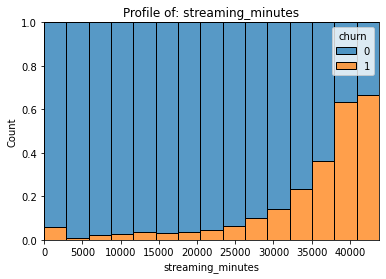

In [56]:
column = "streaming_minutes"

sns.histplot(data=churn, 
            x=column, 
            hue="churn",
            multiple="fill", # -- fill --
            bins=15);
# Add a title to the figure
plt.title('Profile of: {}'.format(column))
plt.show()


In [57]:
churn["rule_1"] = np.where(churn["streaming_minutes"] >= 35000,1,0)


print("-- RULE performance ")
accuracy = accuracy_score(churn["churn"], churn["rule_1"])
print("Accuracy   : {:2.2%}".format(accuracy))
recall = recall_score(churn["churn"],churn["rule_1"])
print("Recall     : {:2.2%}".format(recall))
precision = precision_score(churn["churn"],churn["rule_1"] )
print("Precision  : {:2.2%}".format(precision))

-- RULE performance 
Accuracy   : 94.48%
Recall     : 1.91%
Precision  : 40.25%


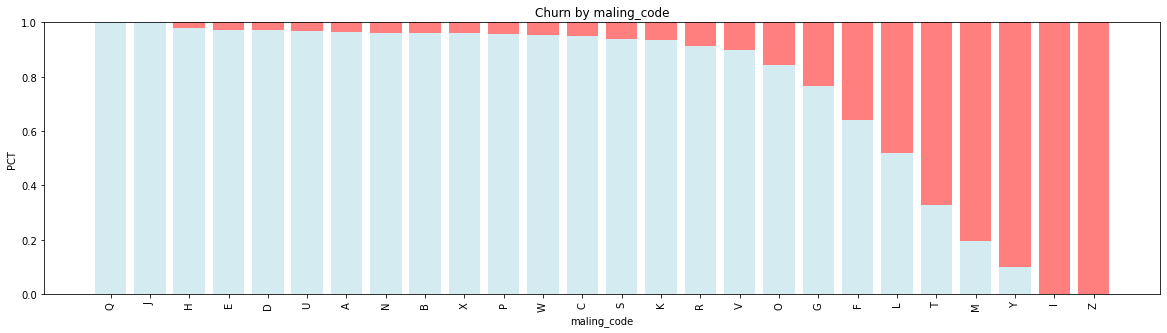

In [58]:
col = "maling_code"

ctab = pd.crosstab(churn[col],churn["churn"], normalize="index").reset_index().sort_values(1).rename(columns={0:"not_churn",1:"churn"})


plt.figure(figsize=(20,5))
# -- check out bottom -- 
plt.bar(ctab[col], ctab["not_churn"], facecolor='lightblue', alpha=0.5)
plt.bar(ctab[col], ctab["churn"], 
        bottom=ctab["not_churn"],  # the bottom of the bar! 
        facecolor='red', alpha=0.5)
plt.title('Churn by ' + col)
plt.ylabel('PCT')
plt.xticks(rotation=90)
plt.xlabel(col)
plt.show()


In [60]:
churn["rule_2"] = np.where(churn["maling_code"].isin(["M","Y","I","Z"]),1,0)


print("-- RULE performance ")
accuracy = accuracy_score(churn["churn"], churn["rule_2"])
print("Accuracy   : {:2.2%}".format(accuracy))
recall = recall_score(churn["churn"],churn["rule_2"])
print("Recall     : {:2.2%}".format(recall))
precision = precision_score(churn["churn"],churn["rule_2"] )
print("Precision  : {:2.2%}".format(precision))

-- RULE performance 
Accuracy   : 94.57%
Recall     : 0.86%
Precision  : 86.00%


# Explore Numerics


---



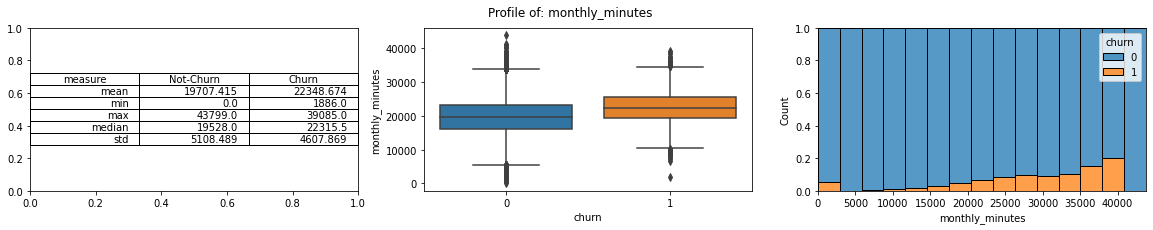

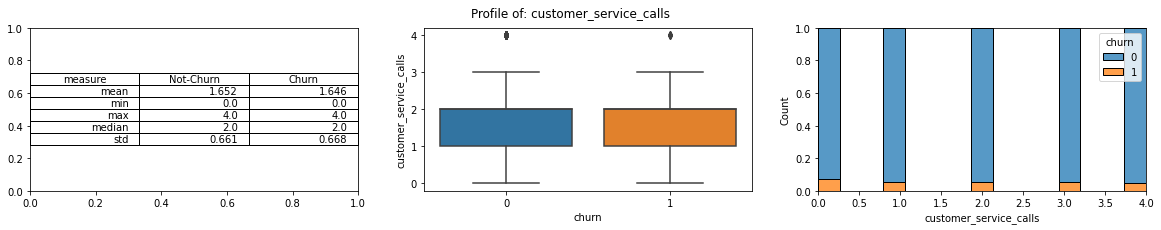

In [61]:
# -- parameterize it! 
# make a function 
def profile_column(column):
  fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 3));

  # get base code working
  res = (churn
        .groupby("churn")
        .agg({column:["mean","min","max","median", "std"]})
        .round(3)
        .reset_index()
        .T
        .reset_index()
        .rename(columns={"level_1":"measure",
                          0:"Not-Churn",
                          1:"Churn"}) # rename the columns 
        .drop("level_0",axis=1) # drop column 
        .drop(index=0) # drop first row
  )

  # make a table object
  table = axs[0].table(cellText=res.values, colLabels=res.columns, loc='center')
  table.auto_set_font_size(False)
  table.set_fontsize(10)


  sns.boxplot(data=churn, 
              y=column, 
              x="churn",
              ax=axs[1]
            )

  sns.histplot(data=churn, 
              x=column, 
              hue="churn",
              multiple="fill", # -- fill --
              bins=15,
              ax=axs[2]);
  # Add a title to the figure
  fig.suptitle('Profile of: {}'.format(column))
  plt.show()


profile_column(column = "monthly_minutes")  
profile_column(column = "customer_service_calls") 

customer_service_calls


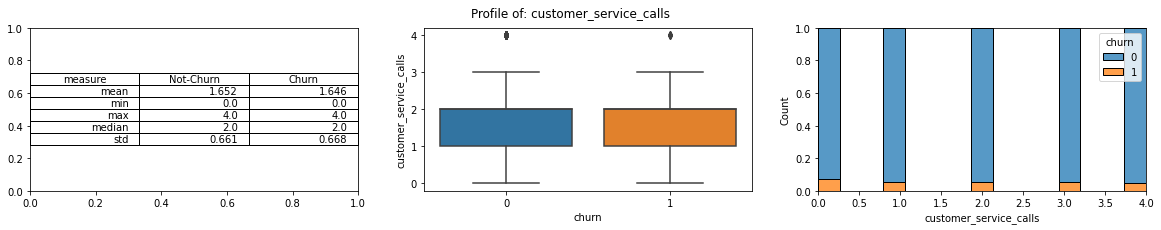

ip_address_asn


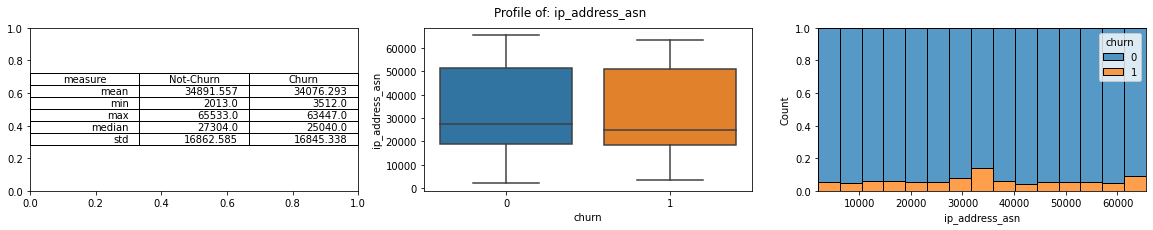

late_payments


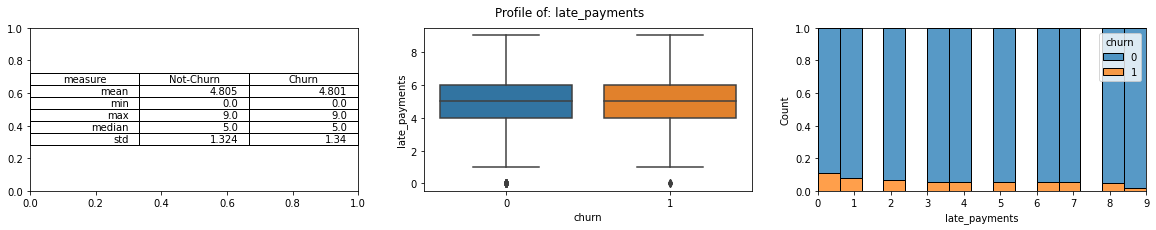

monthly_minutes


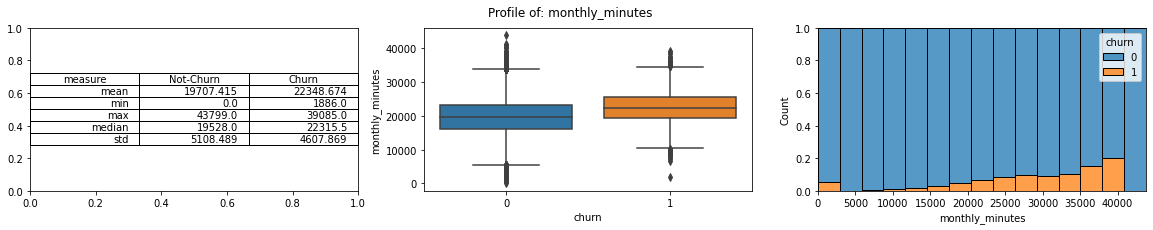

number_phones


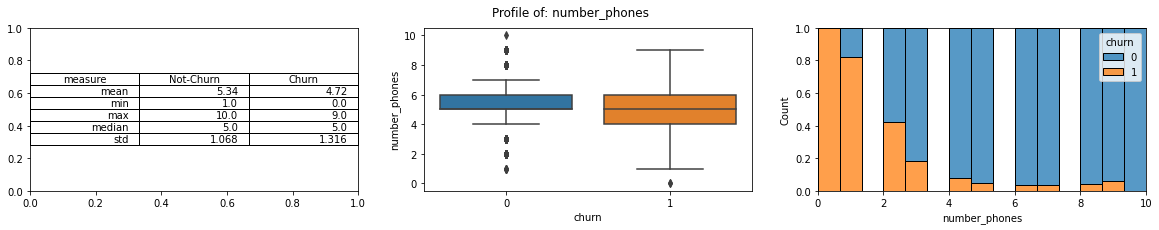

phone_area_code


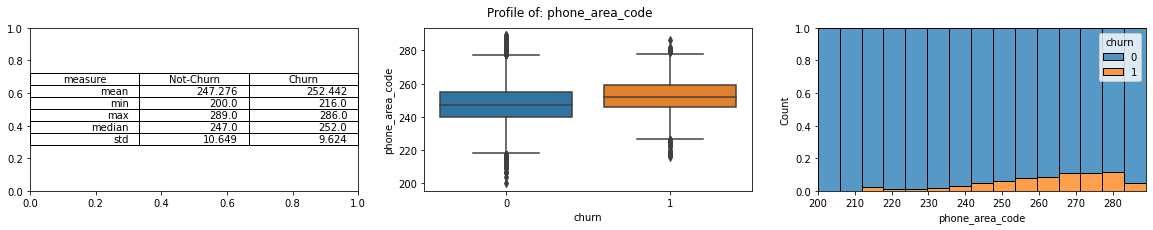

prev_balance


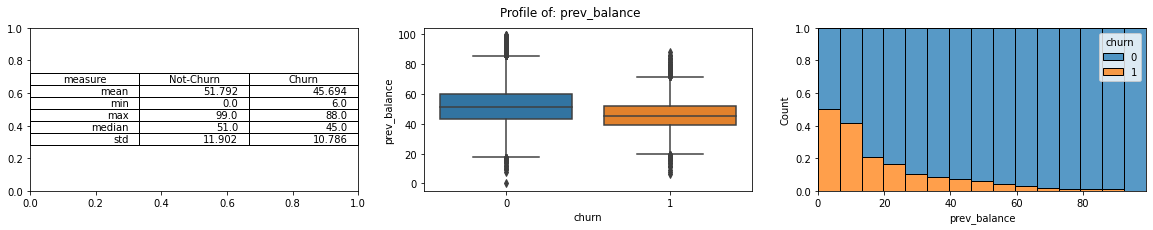

rule_1


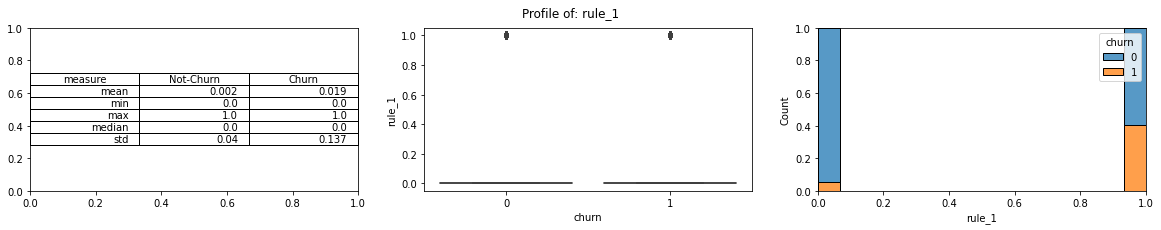

rule_2


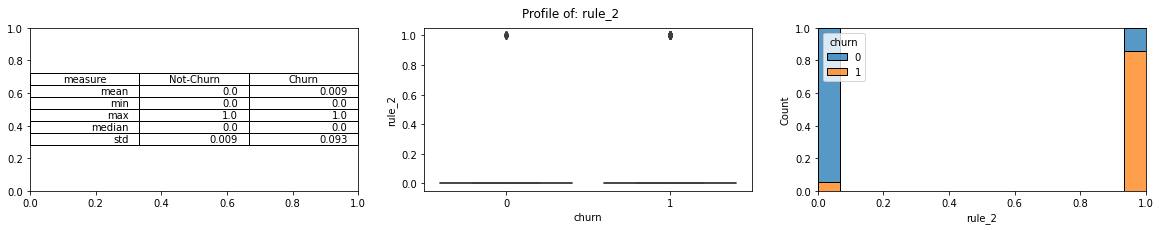

streaming_minutes


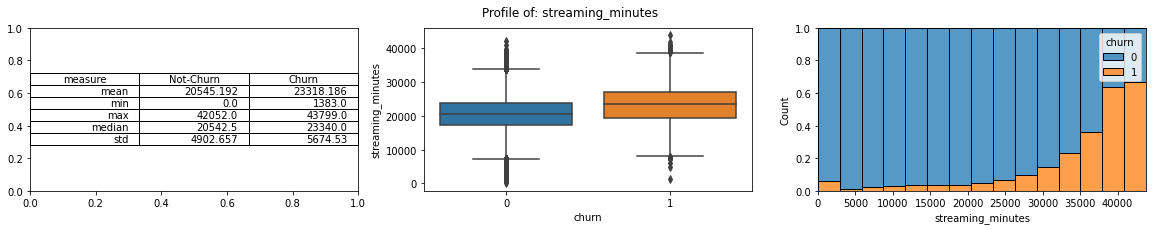

total_billed


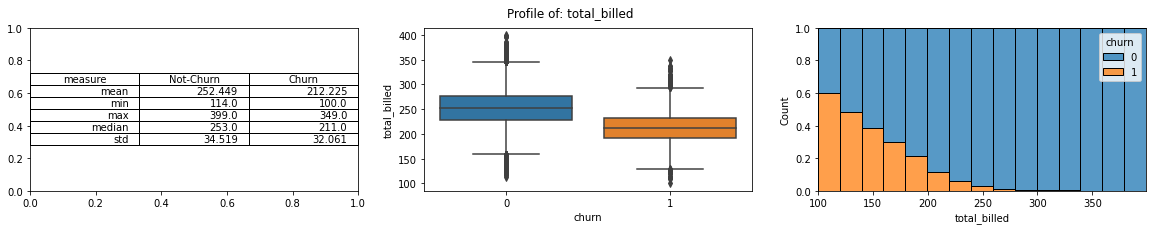

In [62]:
# -- loop -- 
# Get numeric colujmns 
num_cols = churn.select_dtypes(include="number").columns
# Exclude non-numeric columns
num_cols = num_cols.difference(['customer_id','billing_postal','churn', 'senior_citizen'])

# print(num_cols)

# setup loop 
for col in num_cols:
  print(col)
  profile_column(col)  

# Explore Categorical


---

Here's my overly simplistic approach - 

In [25]:
churn.head()

,monthly_minutes,customer_service_calls,streaming_minutes,total_billed,prev_balance,late_payments,ip_address_asn,phone_area_code,customer_reg_date,email_domain,...,maling_code,paperless_billing,payment_method,customer_id,billing_address,gender,network_speed,senior_citizen,churn,rule_1
0,22604.0,2.0,26525.0,285.0,47.0,5.0,16767.0,253.0,2020-04-15,yahoo.com,...,H,No,Mailed Check,1-136-08562-9.1,5592 Gill Pine Suite 387,Female,5G,1.0,0,0
1,17059.0,2.0,16887.0,201.0,45.0,5.0,53966.0,241.0,2020-04-12,gmail.com,...,V,Yes,Mailed Check,0-384-11264-1.2,5806 Kathleen Mount Suite 186,Male,5G,0.0,0,0
2,25848.0,2.0,26783.0,264.0,44.0,6.0,19278.0,232.0,2020-02-22,gmail.com,...,R,Yes,Credit Card,0-08-151665-7.3,5037 Allen Square Apt. 727,Male,5G,1.0,0,0
3,22080.0,3.0,23649.0,274.0,49.0,6.0,16680.0,236.0,2020-08-05,yahoo.com,...,N,No,Mailed Check,0-02-200816-0.4,841 Griffin Route Suite 824,Female,5G,0.0,0,0
4,23871.0,3.0,7705.0,236.0,61.0,5.0,51308.0,243.0,2019-11-16,gmail.com,...,V,Yes,Electronic Check,0-87476-135-2.5,46185 Mejia Manor Apt. 558,Male,4Glte,1.0,0,0


In [26]:
churn.columns

Index(['monthly_minutes', 'customer_service_calls', 'streaming_minutes',
       'total_billed', 'prev_balance', 'late_payments', 'ip_address_asn',
       'phone_area_code', 'customer_reg_date', 'email_domain', 'phone_model',
       'billing_city', 'billing_postal', 'billing_state', 'partner',
       'phone_service', 'multiple_lines', 'streaming_plan', 'mobile_hotspot',
       'wifi_calling_text', 'online_backup', 'device_protection',
       'number_phones', 'contract_code', 'currency_code', 'maling_code',
       'paperless_billing', 'payment_method', 'customer_id', 'billing_address',
       'gender', 'network_speed', 'senior_citizen', 'churn', 'rule_1'],
      dtype='object')

In [27]:
ctab = pd.crosstab(churn["phone_model"],churn["churn"], normalize="index").reset_index().sort_values(1).rename(columns={0:"not_churn",1:"churn"})
ctab

churn,phone_model,not_churn,churn
0,Google Pixel 4 XL,1.000000,0.000000
3,OnePlus 7 Pro,1.000000,0.000000
11,iPhone 11 Pro / Pro Max,1.000000,0.000000
13,iPhone XR,0.984749,0.015251
10,iPhone 11,0.971429,0.028571
5,Samsung Galaxy Note 20 Ultra,0.959917,0.040083
2,Moto G8 Power,0.949520,0.050480
12,iPhone SE 2020,0.949109,0.050891
14,iPhone XS,0.947320,0.052680
7,Samsung Galaxy S10e,0.944002,0.055998


You can see that phone model doesn't really play a role in churn by itself, maybe other variables + phone model are important but the inital assertion of phone model being an important determinant of churn doesn't hold up to the data! 

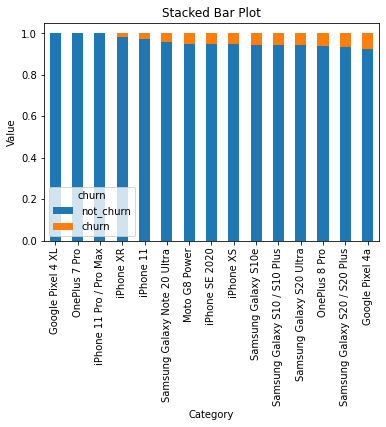

In [28]:
# Create a stacked bar plot
ctab.plot.bar(x='phone_model', stacked=True)
# Add labels and title
plt.xlabel('Category')
plt.ylabel('Value')
plt.title('Stacked Bar Plot')
# Show the plot
plt.show()

phone_model
Best split point ginix: 0.0
churn                    phone_model  not_churn     churn     ginix
0                  Google Pixel 4 XL   1.000000  0.000000  0.000000
3                      OnePlus 7 Pro   1.000000  0.000000  0.000000
11           iPhone 11 Pro / Pro Max   1.000000  0.000000  0.000000
13                         iPhone XR   0.984749  0.015251  0.030036
10                         iPhone 11   0.971429  0.028571  0.055510
5       Samsung Galaxy Note 20 Ultra   0.959917  0.040083  0.076953
2                      Moto G8 Power   0.949520  0.050480  0.095864
12                    iPhone SE 2020   0.949109  0.050891  0.096603
14                         iPhone XS   0.947320  0.052680  0.099809
7                Samsung Galaxy S10e   0.944002  0.055998  0.105725
6      Samsung Galaxy S10 / S10 Plus   0.943927  0.056073  0.105858
9           Samsung Galaxy S20 Ultra   0.942876  0.057124  0.107721
4                      OnePlus 8 Pro   0.940212  0.059788  0.112426
8      S

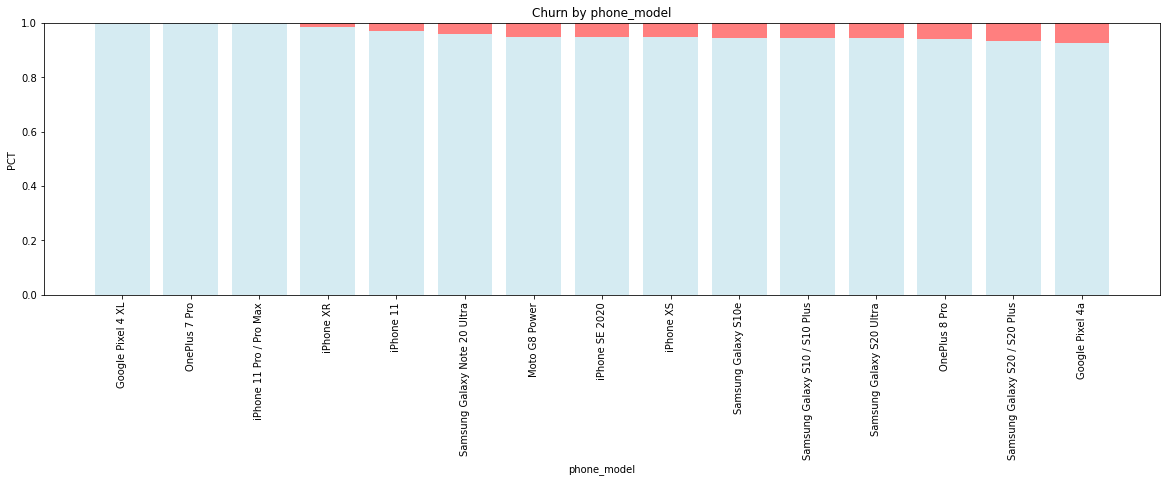

email_domain
Best split point ginix: 0.03578
churn email_domain  not_churn     churn     ginix
2        yahoo.com   0.981778  0.018222  0.035781
0        gmail.com   0.945834  0.054166  0.102464
1      hotmail.com   0.880828  0.119172  0.209940


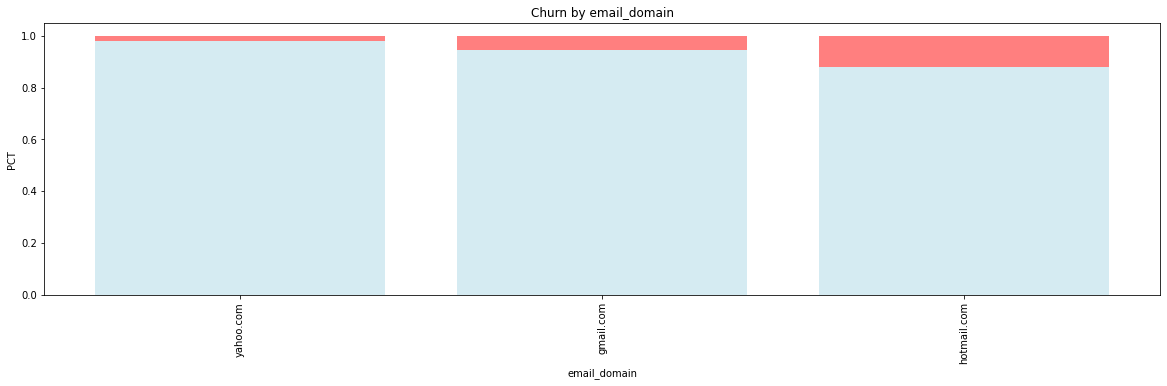

streaming_plan
Best split point ginix: 0.06832
churn streaming_plan  not_churn     churn     ginix
1                3GB   0.964588  0.035412  0.068317
2                6GB   0.960773  0.039227  0.075377
3           Unlmited   0.928840  0.071160  0.132192
0               12GB   0.742284  0.257716  0.382597


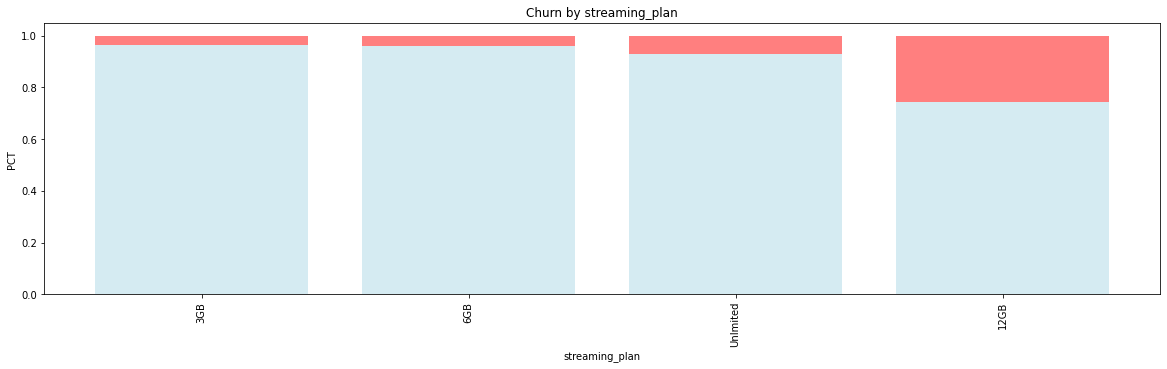

mobile_hotspot
Best split point ginix: 0.05825
churn mobile_hotspot  not_churn     churn     ginix
0                 No   0.969973  0.030027  0.058250
1                Yes   0.925032  0.074968  0.138696


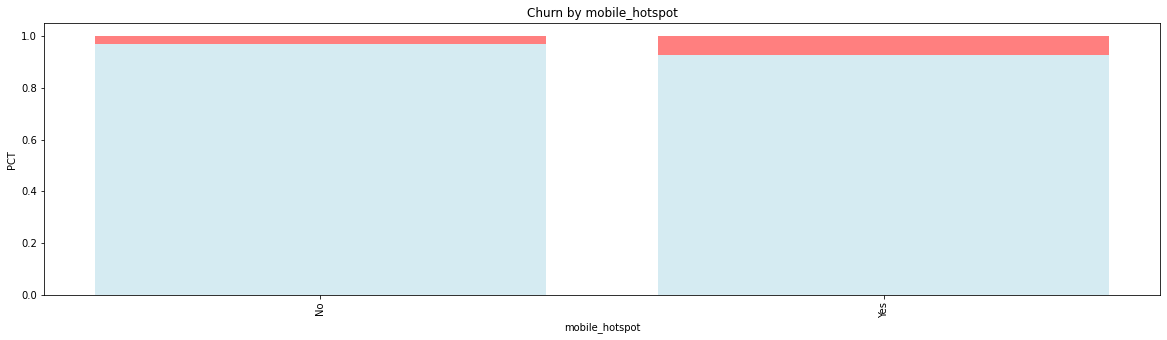

wifi_calling_text
Best split point ginix: 0.1028
churn wifi_calling_text  not_churn     churn     ginix
1                   Yes   0.945637  0.054363  0.102815
0                    No   0.944715  0.055285  0.104458


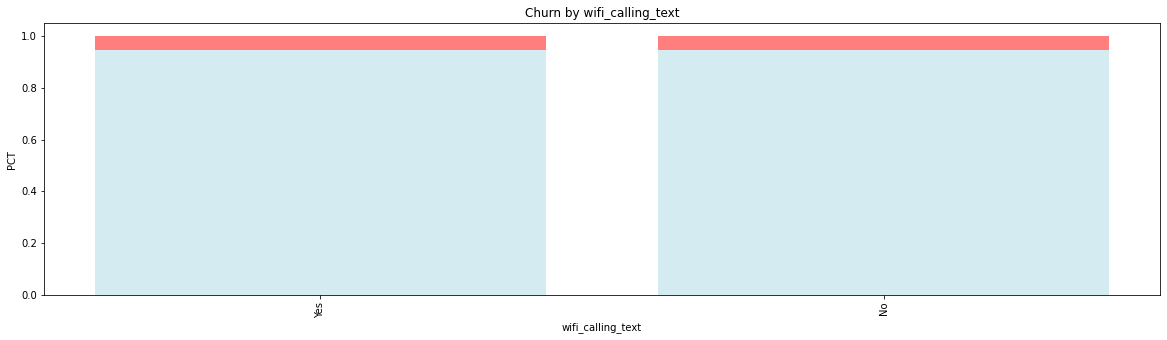

online_backup
Best split point ginix: 0.1009
churn       online_backup  not_churn     churn     ginix
2                     Yes   0.946697  0.053303  0.100923
1      No InternetService   0.943556  0.056444  0.106516
0                      No   0.938602  0.061398  0.115256


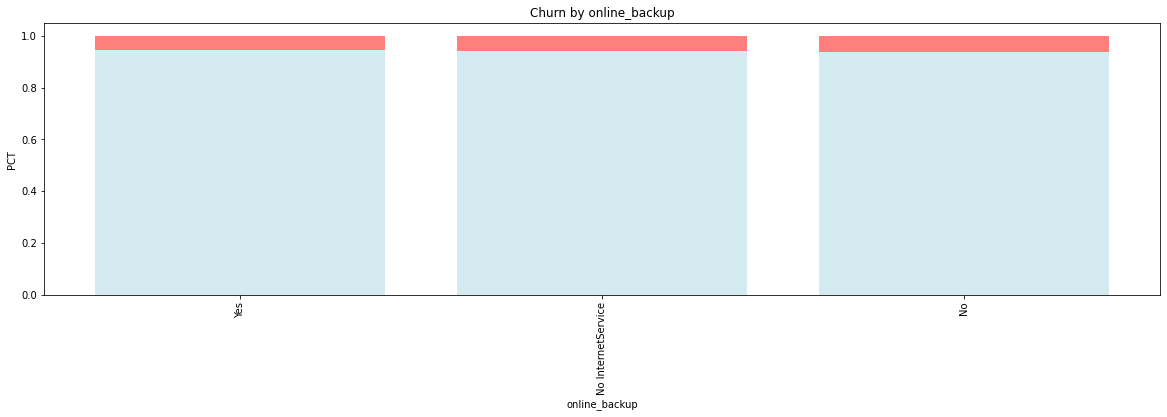

device_protection
Best split point ginix: 0.0
churn device_protection  not_churn     churn     ginix
8                     I   1.000000  0.000000  0.000000
9                     J   1.000000  0.000000  0.000000
16                    Q   1.000000  0.000000  0.000000
10                    K   0.978723  0.021277  0.041648
15                    P   0.958955  0.041045  0.078720
3                     D   0.957265  0.042735  0.081818
7                     H   0.954610  0.045390  0.086660
4                     E   0.953522  0.046478  0.088635
18                    S   0.952223  0.047777  0.090990
21                    V   0.951714  0.048286  0.091909
0                     A   0.951525  0.048475  0.092250
17                    R   0.948383  0.051617  0.097906
14                    O   0.948230  0.051770  0.098179
6                     G   0.945428  0.054572  0.103188
2                     C   0.944858  0.055142  0.104203
13                    N   0.944762  0.055238  0.104373
22                 

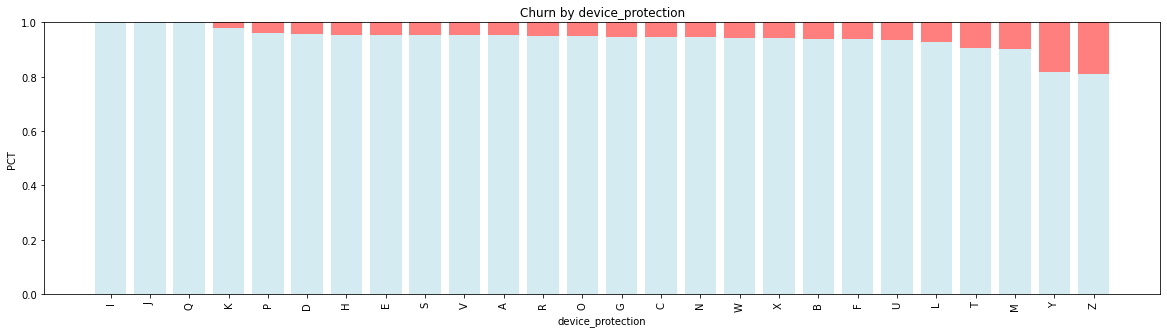

contract_code
Best split point ginix: 0.0
churn contract_code  not_churn     churn     ginix
16                Q   1.000000  0.000000  0.000000
3                 D   1.000000  0.000000  0.000000
15                P   1.000000  0.000000  0.000000
8                 I   1.000000  0.000000  0.000000
9                 J   1.000000  0.000000  0.000000
10                K   1.000000  0.000000  0.000000
25                Z   0.980198  0.019802  0.038820
4                 E   0.980100  0.019900  0.039009
24                Y   0.973684  0.026316  0.051247
19                T   0.969754  0.030246  0.058662
7                 H   0.968254  0.031746  0.061476
12                M   0.967442  0.032558  0.062996
11                L   0.959714  0.040286  0.077327
20                U   0.958333  0.041667  0.079861
0                 A   0.955996  0.044004  0.084136
6                 G   0.955536  0.044464  0.084974
2                 C   0.945557  0.054443  0.102957
22                W   0.945460  0.054540

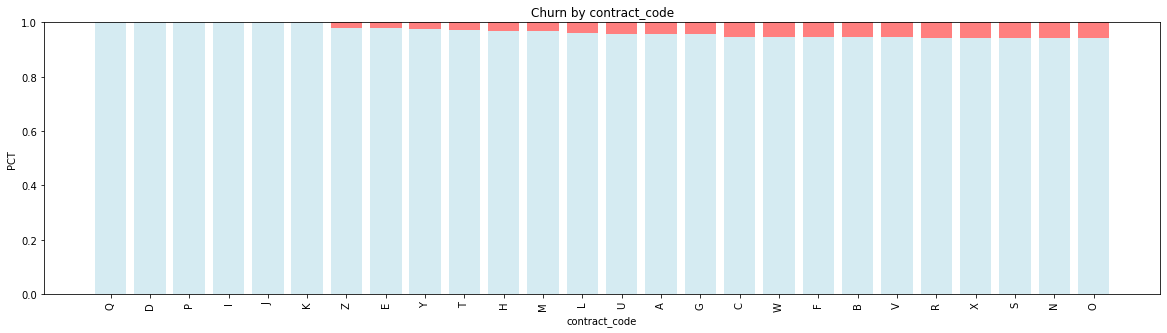

currency_code
Best split point ginix: 0.04905
churn currency_code  not_churn     churn     ginix
2               usd   0.974844  0.025156  0.049047
0               cad   0.952766  0.047234  0.090005
1               eur   0.855045  0.144955  0.247885


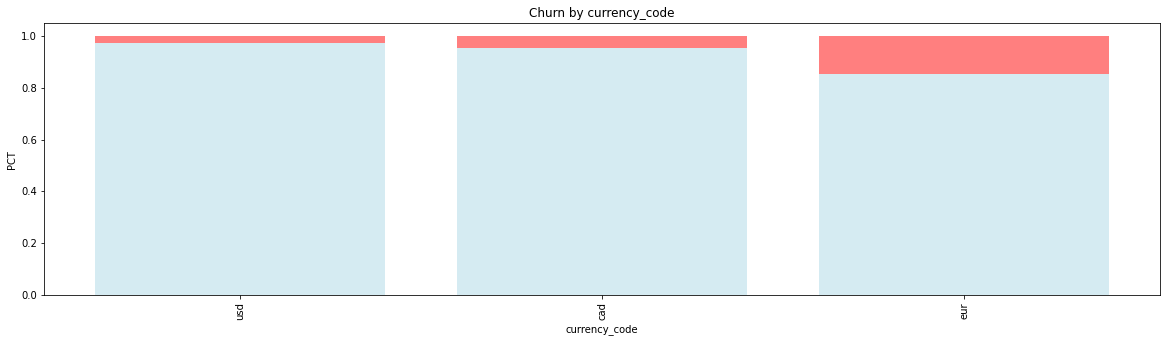

maling_code
Best split point ginix: 0.0
churn maling_code  not_churn     churn     ginix
16              Q   1.000000  0.000000  0.000000
9               J   1.000000  0.000000  0.000000
7               H   0.977273  0.022727  0.044421
4               E   0.970498  0.029502  0.057262
3               D   0.970149  0.029851  0.057919
20              U   0.968013  0.031987  0.061928
0               A   0.965022  0.034978  0.067510
13              N   0.962112  0.037888  0.072905
1               B   0.961680  0.038320  0.073704
23              X   0.961001  0.038999  0.074956
15              P   0.956186  0.043814  0.083789
22              W   0.952515  0.047485  0.090461
2               C   0.949226  0.050774  0.096392
18              S   0.937867  0.062133  0.116544
10              K   0.935484  0.064516  0.120708
17              R   0.914291  0.085709  0.156726
21              V   0.896407  0.103593  0.185723
14              O   0.844326  0.155674  0.262880
6               G   0.763658 

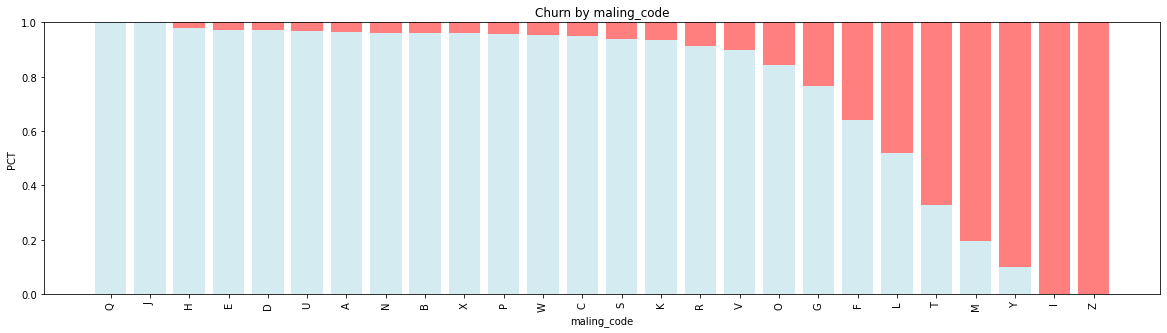

paperless_billing
Best split point ginix: 0.05872
churn paperless_billing  not_churn     churn     ginix
1                   Yes   0.969721  0.030279  0.058725
0                    No   0.923291  0.076709  0.141650


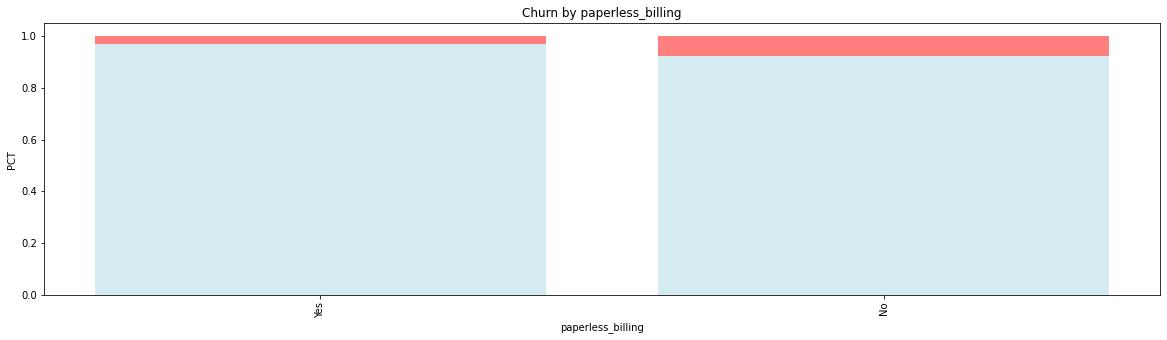

payment_method
Best split point ginix: 0.07228
churn    payment_method  not_churn     churn     ginix
3          Mailed Check   0.962452  0.037548  0.072276
1           Credit Card   0.954420  0.045580  0.087004
2      Electronic Check   0.921336  0.078664  0.144952
0         Bank Transfer   0.576923  0.423077  0.488166


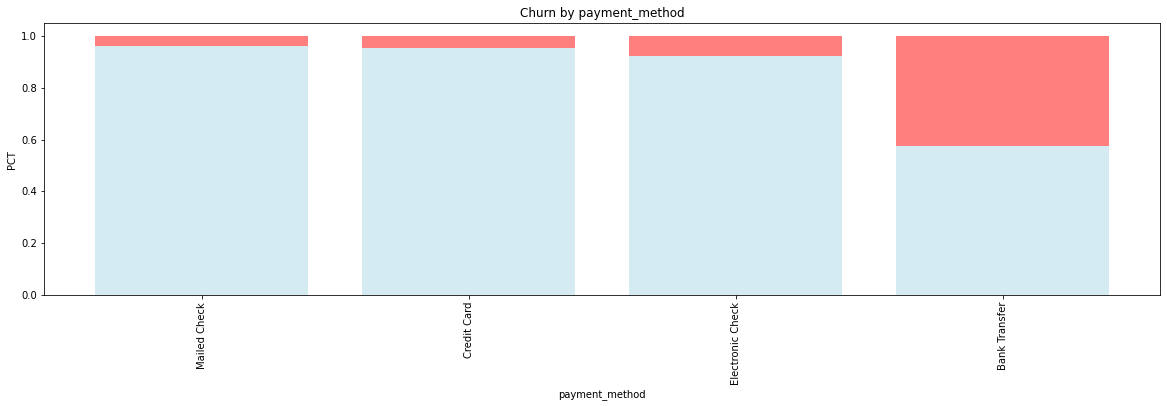

gender
Best split point ginix: 0.1012
churn  gender  not_churn     churn     ginix
1        Male   0.946569  0.053431  0.101152
0      Female   0.943943  0.056057  0.105830


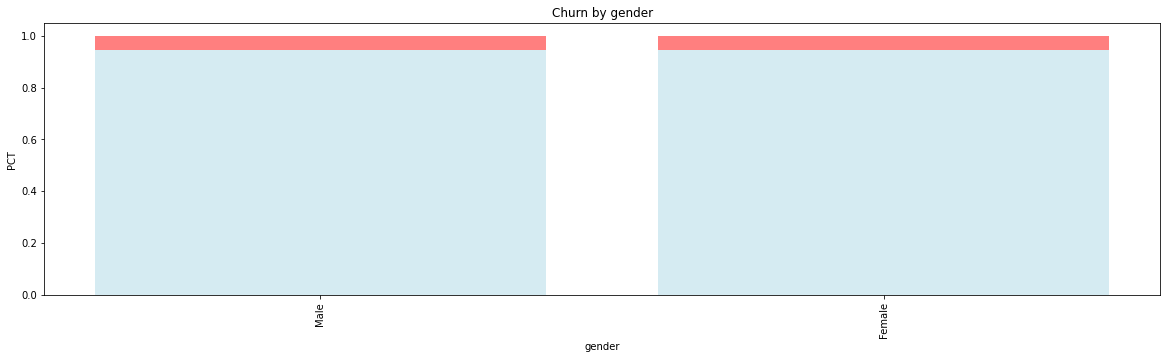

network_speed
Best split point ginix: 0.1014
churn network_speed  not_churn     churn     ginix
1                5G   0.946431  0.053569  0.101398
0             4Glte   0.944118  0.055882  0.105519


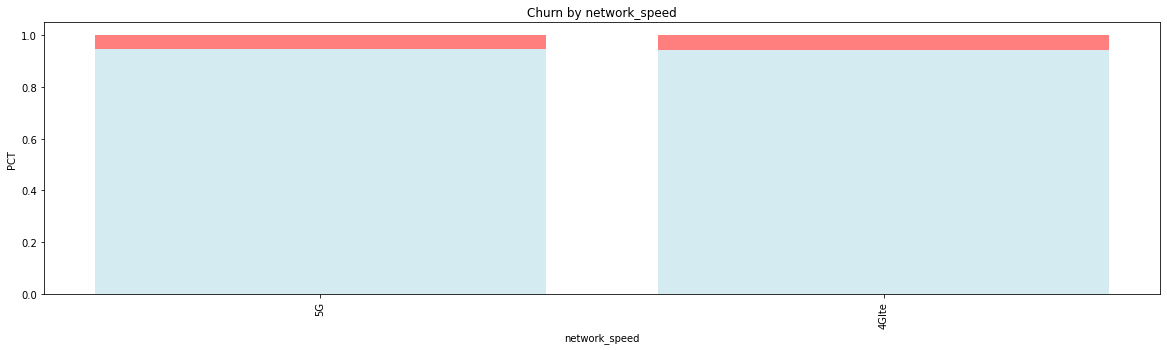

senior_citizen
Best split point ginix: 0.1031
churn  senior_citizen  not_churn     churn     ginix
0                 0.0   0.945504  0.054496  0.103053
1                 1.0   0.945082  0.054918  0.103804


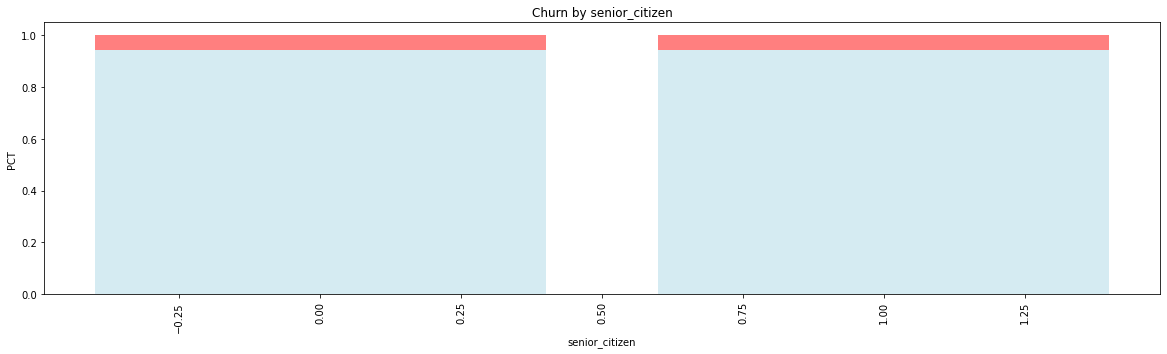

In [63]:
def bar_chars(df, col):
    df = df.copy()
    # -- normalize index converts to row percetages, sort ascending=False means it will sort largest to smallest 
    ctab = pd.crosstab(churn[col],churn["churn"], normalize="index").reset_index().sort_values(1).rename(columns={0:"not_churn",1:"churn"})
    #ctab = pd.crosstab(df[col], df["churn"], normalize="index").reset_index().sort_values('False.',ascending=False )
   
    ctab["ginix"] = 2*ctab["not_churn"]*ctab["churn"]
    
    print("Best split point ginix: {:2.4}".format(ctab["ginix"].min()))
    print(ctab)
  
    plt.figure(figsize=(20,5))
    # -- check out bottom -- 
    plt.bar(ctab[col], ctab["not_churn"], facecolor='lightblue', alpha=0.5)
    plt.bar(ctab[col], ctab["churn"], 
            bottom=ctab["not_churn"],  # the bottom of the bar! 
            facecolor='red', alpha=0.5)
    plt.title('Churn by ' + col)
    plt.ylabel('PCT')
    plt.xticks(rotation=90)
    plt.xlabel(col)
    plt.show()

# -- categorical features of interest 
categorical_features = ["phone_model","email_domain",'streaming_plan', 'mobile_hotspot',
       'wifi_calling_text', 'online_backup', 'device_protection',
        'contract_code', 'currency_code', 'maling_code',
       'paperless_billing', 'payment_method', 
       'gender', 'network_speed', 'senior_citizen']

for col in categorical_features:
    if col != 'churn':
        print(col)
        bar_chars(churn,col)

# Build Decision Tree


---
Here's my basic sugar cookie recipe! 

1. partition data 70/30
2. identify columns and roles as input 
  - target
  - categorical_features
  - numeric_features
3. define pipeline
  - categorical handling:
    - deal with missing values
    - one hot encode categories 
  - numeric handling 
    - deal with missing values 
  - specify the pipeline
  - specify the model 
  - fit it! 
4. visualize 
5. predict and evaluate 



## 1. partition data 70/30


---



In [64]:
train, test = train_test_split(churn,test_size=0.30)

print("train pct: {:2.2%}".format(train.shape[0]/churn.shape[0]))
print("test  pct: {:2.2%}".format(test.shape[0]/churn.shape[0]))

train pct: 70.00%
test  pct: 30.00%


## 2. identify columns and roles as input


---

```python
target = ""
categorical_features = []
numeric_features = []

```

In [65]:
# 0 = not churn, 1 = churn
target = "churn"
print("-- target variable  : {}".format(target))
# -- found durring exploration
categorical_features = ["phone_model","email_domain",'streaming_plan', 'mobile_hotspot',
       'wifi_calling_text', 'online_backup', 'device_protection',
        'contract_code', 'currency_code', 'maling_code',
       'paperless_billing', 'payment_method', 
       'gender', 'network_speed', 'senior_citizen']
print("-- categorical features :")
print(categorical_features)
# -- based on exploration 
numeric_features = ['customer_service_calls', 'ip_address_asn', 'late_payments',
       'monthly_minutes', 'number_phones', 'phone_area_code', 'prev_balance',
       'streaming_minutes', 'total_billed']
print("-- numeric features :")
print(numeric_features)

-- target variable  : churn
-- categorical features :
['phone_model', 'email_domain', 'streaming_plan', 'mobile_hotspot', 'wifi_calling_text', 'online_backup', 'device_protection', 'contract_code', 'currency_code', 'maling_code', 'paperless_billing', 'payment_method', 'gender', 'network_speed', 'senior_citizen']
-- numeric features :
['customer_service_calls', 'ip_address_asn', 'late_payments', 'monthly_minutes', 'number_phones', 'phone_area_code', 'prev_balance', 'streaming_minutes', 'total_billed']


In [32]:
train[numeric_features + categorical_features].head()
test[numeric_features + categorical_features].head()

,customer_service_calls,ip_address_asn,late_payments,monthly_minutes,number_phones,phone_area_code,prev_balance,streaming_minutes,total_billed,phone_model,...,online_backup,device_protection,contract_code,currency_code,maling_code,paperless_billing,payment_method,gender,network_speed,senior_citizen
67010,2.0,23020.0,6.0,25967.0,5.0,256.0,30.0,19400.0,202.0,OnePlus 8 Pro,...,Yes,C,O,cad,O,Yes,Mailed Check,Female,5G,0.0
87433,1.0,54787.0,6.0,21695.0,5.0,247.0,53.0,18683.0,231.0,iPhone XS,...,Yes,A,V,cad,X,No,Electronic Check,Male,5G,1.0
57609,2.0,17878.0,6.0,25844.0,5.0,238.0,33.0,22207.0,259.0,iPhone XS,...,Yes,X,V,cad,C,Yes,Mailed Check,Female,5G,0.0
83324,1.0,51263.0,5.0,11466.0,5.0,239.0,47.0,23770.0,263.0,iPhone SE 2020,...,Yes,U,X,usd,R,No,Electronic Check,Female,5G,1.0
38264,2.0,51381.0,6.0,24478.0,4.0,249.0,56.0,26962.0,287.0,iPhone SE 2020,...,Yes,O,F,cad,B,Yes,Electronic Check,Male,5G,1.0


## 3. Define a Pipeline & Fit the model! 


---

in our case we are going to create a DecisionTreeClassifier key parameters: 

- max_depth: This parameter sets the maximum depth of the decision tree. A deeper tree can capture more complex relationships in the data, but can also lead to overfitting. Setting this parameter too low can result in underfitting. The default value is None, which means the nodes are expanded until all leaves contain less than min_samples_split samples.

- min_samples_split: This parameter sets the minimum number of samples required to split an internal node. This parameter can help prevent overfitting by requiring a minimum number of samples in order to create a new branch. Setting this parameter too high can result in underfitting. The default value is 2.

- ccp_alpha parameter controls tree pruning. Set a positive value for ccp_alpha, the algorithm will prune the tree such that the cost complexity measure is below the threshold specified by ccp_alpha. Higher values of ccp_alpha will result in more aggressive pruning and simpler trees. The default value of ccp_alpha is zero, which means no pruning is performed.


Try setting the following and see how the tree visualizes, rules gneratred and prediction performance. 

TRY different parameters:

- max_depth = 3, 5, 10 and 20
- min_samples_split = 2, 10, 100, and 1000
- ccp_alpha = 0, 0.001,0.0015, 0.0025, 0.005



In [74]:
# Define the column transformer for the categorical variables
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), # handling missing values 
    ('onehot', OneHotEncoder(handle_unknown='ignore'))    # convert categories to 1s and 0s
])

# Define the column transformer for the numeric variables
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))       # replace missing values with median 
])

# Define the full pipeline
preprocessor = ColumnTransformer([
    ('cat', cat_transformer, categorical_features),   # Use one-hot encoding for the first three features
    ('num', num_transformer, numeric_features)  # Use standard scaling for the remaining numeric features
])
# the final pipeline 
decision_tree = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
          max_depth=5,
          #ccp_alpha = 0.0025,
          min_samples_split = 10
                                          )) # play with the parameters
])

# Fit the pipeline to the training data
decision_tree.fit(train[numeric_features + categorical_features], train[target])

# Predict on the train and test data sets
y_pred_train = decision_tree.predict(train[numeric_features + categorical_features])
y_pred_test = decision_tree.predict(test[numeric_features + categorical_features])


## Suppose you want to know what data looks like after 1-hot-encode?


---

you want to look at the "Design Matrix", the data after it's been transformed or you just want to look at only the categorical data post transformation. this is where `.fit_transform()` function comes into play. 

What is happening when you one-hot-encode the data? 
1. for each category in a categorical column is turned into a new column containing a 1 or 0 representing that categorical level
2. the feature names have to be extracted so you can use them. 

In [75]:
# -- gets the categorical column feature names 
transformed_data = cat_transformer.fit_transform(train[categorical_features])

transformed_categorical = cat_transformer['onehot'].get_feature_names_out()
transformed_categorical
print("-- new column names --")
print(transformed_categorical)

transformed_df = pd.DataFrame.sparse.from_spmatrix(transformed_data, columns=transformed_categorical)
print("example post transformation")
transformed_df.head()

-- new column names --
['x0_Google Pixel 4 XL' 'x0_Google Pixel 4a' 'x0_Moto G8 Power'
 'x0_OnePlus 8 Pro' 'x0_Samsung Galaxy Note 20 Ultra'
 'x0_Samsung Galaxy S10 / S10 Plus' 'x0_Samsung Galaxy S10e'
 'x0_Samsung Galaxy S20 / S20 Plus' 'x0_Samsung Galaxy S20 Ultra'
 'x0_iPhone 11' 'x0_iPhone 11 Pro / Pro Max' 'x0_iPhone SE 2020'
 'x0_iPhone XR' 'x0_iPhone XS' 'x1_gmail.com' 'x1_hotmail.com'
 'x1_yahoo.com' 'x2_12GB' 'x2_3GB' 'x2_6GB' 'x2_Unlmited' 'x3_No' 'x3_Yes'
 'x4_No' 'x4_Yes' 'x5_No' 'x5_No InternetService' 'x5_Yes' 'x6_A' 'x6_B'
 'x6_C' 'x6_D' 'x6_E' 'x6_F' 'x6_G' 'x6_H' 'x6_I' 'x6_J' 'x6_K' 'x6_L'
 'x6_M' 'x6_N' 'x6_O' 'x6_P' 'x6_Q' 'x6_R' 'x6_S' 'x6_T' 'x6_U' 'x6_V'
 'x6_W' 'x6_X' 'x6_Y' 'x6_Z' 'x7_A' 'x7_B' 'x7_C' 'x7_D' 'x7_E' 'x7_F'
 'x7_G' 'x7_H' 'x7_I' 'x7_J' 'x7_K' 'x7_L' 'x7_M' 'x7_N' 'x7_O' 'x7_P'
 'x7_Q' 'x7_R' 'x7_S' 'x7_T' 'x7_U' 'x7_V' 'x7_W' 'x7_X' 'x7_Y' 'x7_Z'
 'x8_cad' 'x8_eur' 'x8_usd' 'x9_A' 'x9_B' 'x9_C' 'x9_D' 'x9_E' 'x9_F'
 'x9_G' 'x9_H' 'x9_K' 'x9_L' 'x

,x0_Google Pixel 4 XL,x0_Google Pixel 4a,x0_Moto G8 Power,x0_OnePlus 8 Pro,x0_Samsung Galaxy Note 20 Ultra,x0_Samsung Galaxy S10 / S10 Plus,x0_Samsung Galaxy S10e,x0_Samsung Galaxy S20 / S20 Plus,x0_Samsung Galaxy S20 Ultra,x0_iPhone 11,...,x11_Bank Transfer,x11_Credit Card,x11_Electronic Check,x11_Mailed Check,x12_Female,x12_Male,x13_4Glte,x13_5G,x14_0.0,x14_1.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


## 4. Visualize the Tree


---

Since we use transformations, like one-hot-encoding, that GENERATE new columns (features) we need to extract the new feature names. to do this we use `.get_feature_names_out()` function to return the featue names as an array. like this:

```python
# -- gets the categorical column feature names 
transformed_data = cat_transformer.fit_transform(train[categorical_features])

transformed_categorical = cat_transformer['onehot'].get_feature_names_out()
transformed_categorical
print("-- new column names --")
print(transformed_categorical)

```
We finally need to combine the new categorical features with the numeric features into a single list of features for visualization, let's check it out. 

> NOTE: the order is important if your preprocessor has categorical transforms first you need the categorical features first. 


In [69]:
# make a list of all features 
all_features =  transformed_categorical.tolist() + numeric_features 
print(all_features)

['x0_Google Pixel 4 XL', 'x0_Google Pixel 4a', 'x0_Moto G8 Power', 'x0_OnePlus 8 Pro', 'x0_Samsung Galaxy Note 20 Ultra', 'x0_Samsung Galaxy S10 / S10 Plus', 'x0_Samsung Galaxy S10e', 'x0_Samsung Galaxy S20 / S20 Plus', 'x0_Samsung Galaxy S20 Ultra', 'x0_iPhone 11', 'x0_iPhone 11 Pro / Pro Max', 'x0_iPhone SE 2020', 'x0_iPhone XR', 'x0_iPhone XS', 'x1_gmail.com', 'x1_hotmail.com', 'x1_yahoo.com', 'x2_12GB', 'x2_3GB', 'x2_6GB', 'x2_Unlmited', 'x3_No', 'x3_Yes', 'x4_No', 'x4_Yes', 'x5_No', 'x5_No InternetService', 'x5_Yes', 'x6_A', 'x6_B', 'x6_C', 'x6_D', 'x6_E', 'x6_F', 'x6_G', 'x6_H', 'x6_I', 'x6_J', 'x6_K', 'x6_L', 'x6_M', 'x6_N', 'x6_O', 'x6_P', 'x6_Q', 'x6_R', 'x6_S', 'x6_T', 'x6_U', 'x6_V', 'x6_W', 'x6_X', 'x6_Y', 'x6_Z', 'x7_A', 'x7_B', 'x7_C', 'x7_D', 'x7_E', 'x7_F', 'x7_G', 'x7_H', 'x7_I', 'x7_J', 'x7_K', 'x7_L', 'x7_M', 'x7_N', 'x7_O', 'x7_P', 'x7_Q', 'x7_R', 'x7_S', 'x7_T', 'x7_U', 'x7_V', 'x7_W', 'x7_X', 'x7_Y', 'x7_Z', 'x8_cad', 'x8_eur', 'x8_usd', 'x9_A', 'x9_B', 'x9_C', 'x

### To visualize the tree


---
We are going to extract the tree part from the pipeline then use the graphviz and tree libraries to visualize it. 



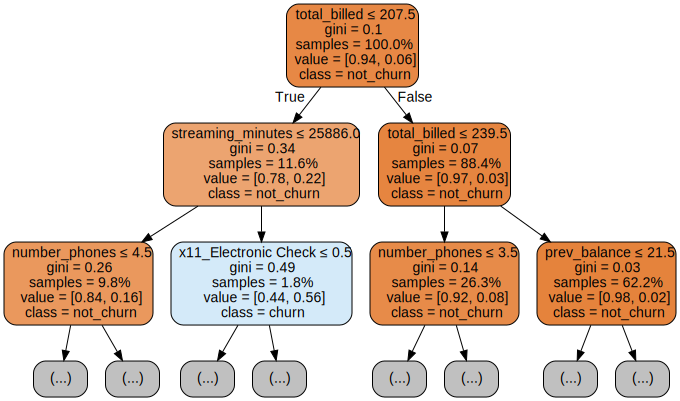

In [76]:
# -- chart of tree 

import graphviz 
from sklearn import tree
# Extract the decision tree from the pipeline
dt_tree = decision_tree.named_steps['classifier']

# visualize the treee
dot_data = tree.export_graphviz(dt_tree, 
                                out_file=None,
            feature_names = all_features,
            class_names=["not_churn", "churn"],
            max_depth = 2, # controll how deep to visualize
            filled=True, 
            rounded=True,  
            proportion=True,
                           precision=2,
            special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

## Feature Importance 

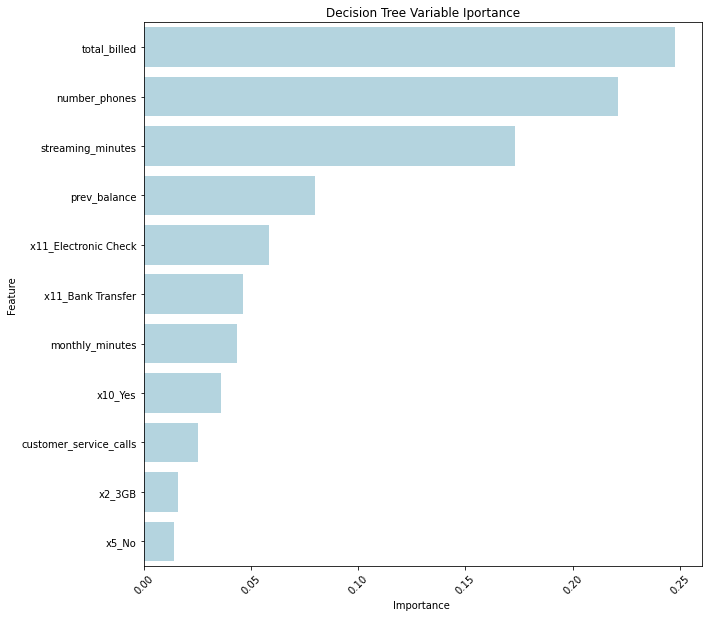

In [77]:
# -- get feature importance 
importance = dt_tree.feature_importances_

# -- summarize feature importance into a dictionary 
feature_imp ={}
for i,v in enumerate(importance):
    feature_imp[all_features[i]] = v

# make the dictionary a data frame 
feature_imp = pd.DataFrame.from_dict(feature_imp, orient='index',
                                     columns=['importance'])

# -- prep and filter our dataframe, only need to look at the important features i.e. things > 0 
feature_imp = (feature_imp
               .reset_index()
               .rename(columns={'index':'feature'})
               .sort_values('importance',ascending=False)
               .query('importance > 0.01'))

# -- plot that 
plt.figure(figsize=(10,10))
sns.barplot(x="importance", y="feature", data=feature_imp, color="lightblue")
plt.title('Decision Tree Variable Iportance')
plt.ylabel('Feature')
plt.xlabel('Importance ')
plt.xticks(rotation=45)
plt.show()

### Export Business rules 


---

Simple way to extract some rules that you can share with an executive. 

In [78]:
from sklearn.tree import DecisionTreeClassifier, export_text

# Extract the business rules from the decision tree
r = export_text(dt_tree, feature_names=all_features, show_weights=True)

# Print the business rules
print(r)



|--- total_billed <= 207.50
|   |--- streaming_minutes <= 25886.00
|   |   |--- number_phones <= 4.50
|   |   |   |--- number_phones <= 3.50
|   |   |   |   |--- monthly_minutes <= 16726.50
|   |   |   |   |   |--- weights: [13.00, 2.00] class: 0
|   |   |   |   |--- monthly_minutes >  16726.50
|   |   |   |   |   |--- weights: [44.00, 214.00] class: 1
|   |   |   |--- number_phones >  3.50
|   |   |   |   |--- x5_No <= 0.50
|   |   |   |   |   |--- weights: [391.00, 171.00] class: 0
|   |   |   |   |--- x5_No >  0.50
|   |   |   |   |   |--- weights: [62.00, 111.00] class: 1
|   |   |--- number_phones >  4.50
|   |   |   |--- monthly_minutes <= 23177.50
|   |   |   |   |--- x2_12GB <= 0.50
|   |   |   |   |   |--- weights: [3814.00, 212.00] class: 0
|   |   |   |   |--- x2_12GB >  0.50
|   |   |   |   |   |--- weights: [9.00, 14.00] class: 1
|   |   |   |--- monthly_minutes >  23177.50
|   |   |   |   |--- prev_balance <= 45.50
|   |   |   |   |   |--- weights: [743.00, 107.00] class:

## 5.  Predict 


---

The goal of classification tasks is to predict a categorical output variable based on a set of input features. In our case the "target" can take a 0 = not_churn and a 1 = churn. When making predictions we have two functions we need to be aware of. 

- `.predict(X)` : takes a set of input features as input and returns the predicted **class** for each instance. It does the by calculating the predicted probabilty for each class and assigns the "positive" class if the predicted probably of the postitive class is >= 0.5

- `.predict_proba(X)` : takes in the set of input features as input and returns the **predicted probabilites** for each class.  Typically, you will operate a ML model based on the predicted probabilites not the predicted class. 



In [79]:
# train predictions 
train["predicted_class"] = decision_tree.predict(train[numeric_features + categorical_features])
train["predicted_prob0"], train["predicted_prob1"] = decision_tree.predict_proba(train[numeric_features + categorical_features]).T
train[["churn","predicted_class","predicted_prob0","predicted_prob1"]]\
.query('predicted_prob1 > 0.25 and predicted_prob1 < 0.75').head(10)

,churn,predicted_class,predicted_prob0,predicted_prob1
54101,1,0,0.695730,0.304270
36287,1,0,0.695730,0.304270
42530,0,0,0.695730,0.304270
8580,0,0,0.590778,0.409222
31319,0,1,0.358382,0.641618
71488,1,0,0.695730,0.304270
19552,1,0,0.643836,0.356164
83468,0,0,0.695730,0.304270
14804,1,0,0.590778,0.409222
41143,1,1,0.358382,0.641618


In [82]:
test["predicted_class"] = decision_tree.predict(test[numeric_features + categorical_features])
test["predicted_prob0"], test["predicted_prob1"] = decision_tree.predict_proba(test[numeric_features + categorical_features]).T
test[["churn","predicted_class","predicted_prob0","predicted_prob1"]].head(10)

,churn,predicted_class,predicted_prob0,predicted_prob1
85987,0,0,0.987563,0.012437
13426,0,0,0.987563,0.012437
53030,0,0,0.947342,0.052658
55151,0,0,0.987563,0.012437
26731,0,0,0.987563,0.012437
34869,0,0,0.987563,0.012437
26293,0,0,0.951379,0.048621
534,0,0,0.951379,0.048621
54215,0,0,0.987563,0.012437
15613,0,0,0.987563,0.012437


## Confusion Matrix 


---




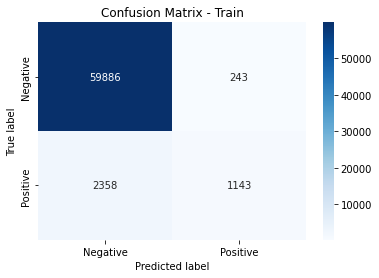

In [80]:
from sklearn.metrics import confusion_matrix
# Compute the confusion matrix
cm = confusion_matrix(train[target], train["predicted_class"])

# Define the labels for the confusion matrix
labels = ["Negative", "Positive"]

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels);
plt.title("Confusion Matrix - Train")
# Update the x and y axis labels
plt.xlabel("Predicted label")
plt.ylabel("True label");


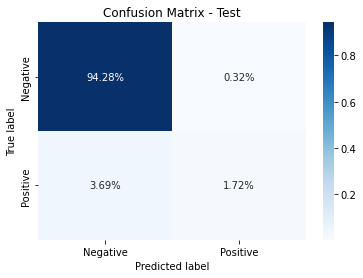

In [83]:
cm = confusion_matrix(test[target], test["predicted_class"])

# Define the labels for the confusion matrix
labels = ["Negative", "Positive"]
total = float(cm.sum())
# Create a heatmap of the confusion matrix
sns.heatmap(cm/total, annot=True, cmap="Blues", fmt='.2%', xticklabels=labels, yticklabels=labels);
plt.title("Confusion Matrix - Test")
# Update the x and y axis labels
plt.xlabel("Predicted label")
plt.ylabel("True label");

## Evaluate 


---

Calculate the following 
- accuracy
- recall
- precision

In [84]:
data_sets = {"train":train,
             "test": test}

for i in data_sets.keys():
  print("-- partition: {} --".format(i))
  accuracy = accuracy_score(data_sets[i][target], data_sets[i]["predicted_class"])
  print("Accuracy   : {:2.2%}".format(accuracy))
  recall = recall_score(data_sets[i][target].values,data_sets[i]["predicted_class"] )
  print("Recall     : {:2.2%}".format(recall))
  precision = precision_score(data_sets[i][target].values,data_sets[i]["predicted_class"] )
  print("Precision  : {:2.2%}".format(precision))


-- partition: train --
Accuracy   : 95.91%
Recall     : 32.65%
Precision  : 82.47%
-- partition: test --
Accuracy   : 96.00%
Recall     : 31.75%
Precision  : 84.48%


## What happens if... 


---

Your boss says great! BUT can you improve the RECALL of the model by changing the predicted probability down to 0.25 and in another scenario they want you to crank the predicted probably threshold up to 0.75. 


Effectively 
1. scenario 1: find more churners at expense of higher false positives 
> IF predicted_prob1 >= 0.25 then predicted_churn
2. scenario 2: find fewer churners at expense of lower RECALL
> IF predicted_prob1 >= 0.75 then predicted_churn




lets create two new class assignments 
```python

# Update the predicted_prob1 column based on a threshold of 0.25
test["scenario_1"] = np.where(test["predicted_prob1"] >= 0.25, 0, 1)

test["scenario_2"] = np.where(test["predicted_prob1"] >= 0.75, 0, 1)
```



In [85]:
train["scenario_1"] = np.where(train["predicted_prob1"] >= 0.25, 1, 0)
train["scenario_2"] = np.where(train["predicted_prob1"] >= 0.75, 1, 0)

test["scenario_1"] = np.where(test["predicted_prob1"] >= 0.25, 1, 0)
test["scenario_2"] = np.where(test["predicted_prob1"] >= 0.75, 1, 0)

data_sets = {"train":train,
             "test": test}

for i in data_sets.keys():
  print("-- scenario 1 partition: {} --".format(i))
  accuracy = accuracy_score(data_sets[i][target], data_sets[i]["scenario_1"])
  print("Accuracy   : {:2.2%}".format(accuracy))
  recall = recall_score(data_sets[i][target].values,data_sets[i]["scenario_1"] )
  print("Recall     : {:2.2%}".format(recall))
  precision = precision_score(data_sets[i][target].values,data_sets[i]["scenario_1"] )
  print("Precision  : {:2.2%}".format(precision))

print("\n")

for i in data_sets.keys():
  print("-- scenario 2 partition: {} --".format(i))
  accuracy = accuracy_score(data_sets[i][target], data_sets[i]["scenario_2"])
  print("Accuracy   : {:2.2%}".format(accuracy))
  recall = recall_score(data_sets[i][target].values,data_sets[i]["scenario_2"] )
  print("Recall     : {:2.2%}".format(recall))
  precision = precision_score(data_sets[i][target].values,data_sets[i]["scenario_2"] )
  print("Precision  : {:2.2%}".format(precision))

-- scenario 1 partition: train --
Accuracy   : 95.25%
Recall     : 45.36%
Precision  : 58.88%
-- scenario 1 partition: test --
Accuracy   : 95.28%
Recall     : 43.83%
Precision  : 58.51%


-- scenario 2 partition: train --
Accuracy   : 95.80%
Recall     : 28.02%
Precision  : 86.74%
-- scenario 2 partition: test --
Accuracy   : 95.85%
Recall     : 27.61%
Precision  : 86.05%
